2025-08-26 16:02:20,477 - INFO - Loading data from D:\Minor Project\All Models\Interval_Forecast_Normal\df_without_exo.xlsx...
2025-08-26 16:02:21,072 - INFO - Engineering lagged features...
2025-08-26 16:02:21,083 - INFO - Splitting test data at date: 2024-04-01
2025-08-26 16:02:21,092 - INFO - Train size: 750, Validation size: 84, Test size: 89
2025-08-26 16:02:21,101 - INFO - Starting hyperparameter search over 1566 combinations...
2025-08-26 16:02:26,170 - INFO - ✓ Valid model found: PICP=98.78%, MPIW=21.6407 with params {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100}
2025-08-26 16:02:26,769 - INFO - ✓ Valid model found: PICP=96.34%, MPIW=17.0859 with params {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100}
2025-08-26 16:02:27,699 - INFO - ✓ Valid model found: PICP=98.78%, MPIW=37.3916 with params {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100}
2025-08-26 16:02:28


Best Hyperparameters: {'seq_len': 10, 'hidden_dim': 48, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100}
Prediction Interval Coverage (PICP): 100.00%
Mean Prediction Interval Width (MPIW): 17.5844



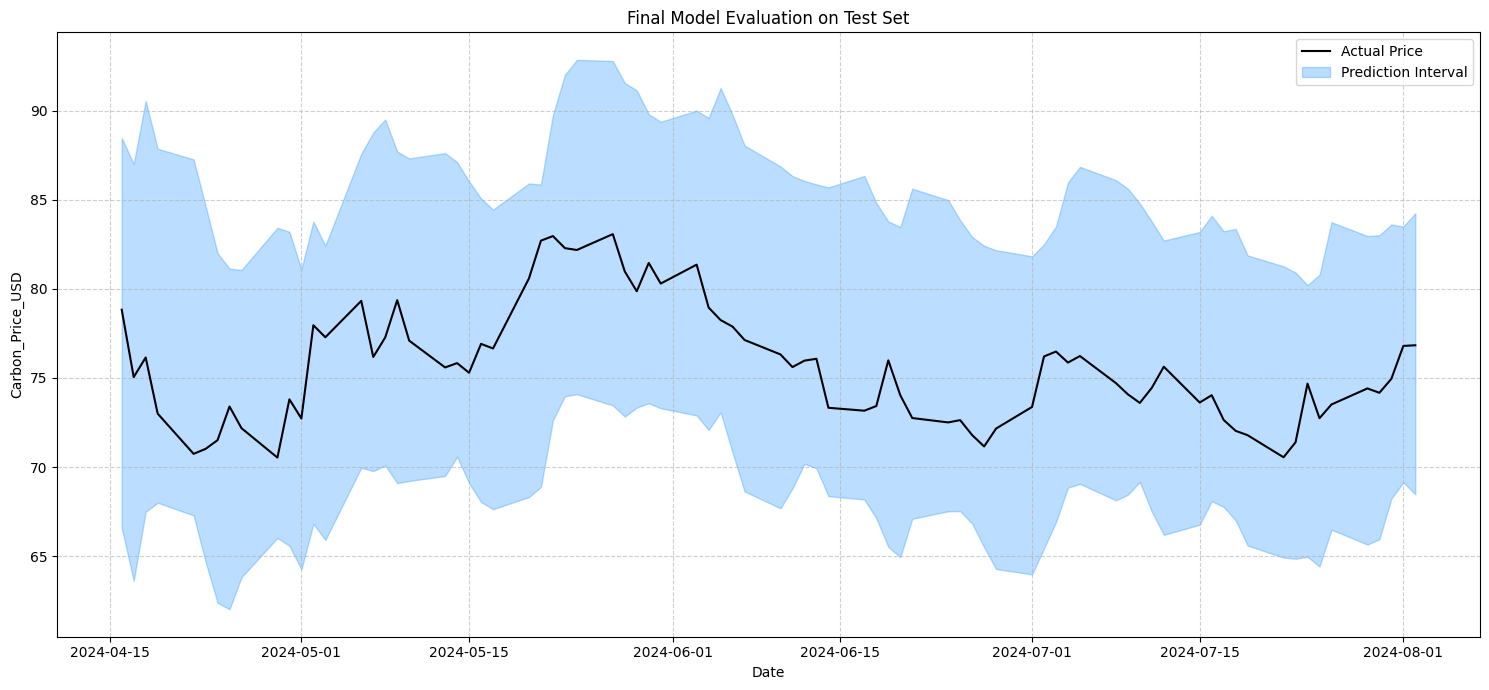

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import itertools
import logging

# --- 1. Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "file_path": r"D:\Minor Project\All Models\Interval_Forecast_Normal\df_without_exo.xlsx",
    "target_col": "Carbon_Price_USD",
    "original_features": ['Open', 'High', 'Low', 'Carbon_Price_USD', 'Vol.', 'Change %'],
    
    # --- New Splitting Logic ---
    "test_split_date": '2024-04-01',
    "val_ratio_of_train_data": 0.1, # 10% of the pre-2024 data is used for validation
    
    "target_coverage": 95.0,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "param_grid": {
        'seq_len': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
        'hidden_dim': [32, 48, 64, 96, 128, 160],
        'num_layers': [1, 2, 3],
        'learning_rate': [0.005, 0.01, 0.001],
        'epochs': [100]
    }
}

# --- 2. Model Definition ---
class RNNQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# --- 3. Pipeline Functions ---

def load_and_clean_data(file_path):
    # This function remains the same as the robust version from before
    logging.info(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path) 
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.sort_values('Date', inplace=True)

    if pd.api.types.is_object_dtype(df['Vol.']):
        logging.info("Volume column contains text. Applying conversion...")
        def convert_volume(vol):
            try:
                if isinstance(vol, str):
                    vol = vol.replace('K', '*1e3').replace('M', '*1e6')
                    return eval(vol)
                return np.nan
            except:
                return np.nan
        df['Vol.'] = df['Vol.'].apply(convert_volume)
    
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')
    df.set_index('Date', inplace=True)
    return df

def engineer_features(df, original_features, target_col):
    # This function also remains the same
    logging.info("Engineering lagged features...")
    for feature in original_features:
        df[f'{feature}_lag1'] = df[feature].shift(1)
    
    feature_cols = [f'{col}_lag1' for col in original_features]
    df.dropna(inplace=True)
    
    if df.empty:
        raise ValueError("DataFrame is empty after feature engineering. Please check input data.")
    
    X = df[feature_cols]
    y = df[[target_col]]
    return X, y

def split_and_scale_data(X, y, test_split_date, val_ratio):
    """
    Splits data into train, validation, and test sets.
    """
    logging.info(f"Splitting test data at date: {test_split_date}")
    test_split_date = pd.to_datetime(test_split_date)

    train_val_mask = X.index < test_split_date
    X_train_val, X_test = X[train_val_mask], X[~train_val_mask]
    y_train_val, y_test = y[train_val_mask], y[~train_val_mask]

    val_split_index = int(len(X_train_val) * (1 - val_ratio))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]

    logging.info(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
         raise ValueError("One of the data splits is empty. Check your split date and ratios.")

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)

    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)
    
    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
            X_test_scaled, y_test_scaled, scaler_y)

def create_sequences(X, y, seq_len):
    # This utility function remains the same
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def train_quantile_model(X_train, y_train, quantile, params):
    # This training utility also remains the same
    model = RNNQuantile(
        X_train.shape[2], 
        params['hidden_dim'], 
        params['num_layers']
    ).to(CONFIG['device'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(CONFIG['device'])
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(CONFIG['device'])

    def quantile_loss(q, y, y_pred):
        e = y - y_pred
        return torch.mean(torch.max(q * e, (q - 1) * e))

    for _ in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

def find_best_hyperparameters(train_data, val_data, param_grid, scaler_y):
    """Searches for the best hyperparameters on the validation set."""
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data
    
    valid_models = []
    param_combinations = list(itertools.product(*param_grid.values()))
    logging.info(f"Starting hyperparameter search over {len(param_combinations)} combinations...")

    for values in param_combinations:
        params = dict(zip(param_grid.keys(), values))
        
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, params['seq_len'])
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, params['seq_len'])

        if len(X_val_seq) == 0: continue

        lower_model = train_quantile_model(X_train_seq, y_train_seq, 0.025, params)
        upper_model = train_quantile_model(X_train_seq, y_train_seq, 0.975, params)

        X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(CONFIG['device'])
        with torch.no_grad():
            pred_lower_s = lower_model(X_val_t).cpu().numpy()
            pred_upper_s = upper_model(X_val_t).cpu().numpy()

        pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
        pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
        y_val_true = scaler_y.inverse_transform(y_val_seq).flatten()
        
        # Ensure upper bound is always greater than or equal to lower bound
        pred_upper = np.maximum(pred_lower, pred_upper)

        picp = np.mean((y_val_true >= pred_lower) & (y_val_true <= pred_upper)) * 100
        mpiw = np.mean(pred_upper - pred_lower)

        if picp >= CONFIG['target_coverage']:
            logging.info(f"✓ Valid model found: PICP={picp:.2f}%, MPIW={mpiw:.4f} with params {params}")
            valid_models.append({'mpiw': mpiw, 'params': params})
        else:
            logging.info(f"✗ Model rejected: PICP={picp:.2f}% with params {params}")

    if not valid_models:
        raise ValueError("No valid hyperparameters found that meet the PICP threshold on the validation set.")
        
    # Select the parameters with the lowest MPIW from the valid models
    best_model_info = min(valid_models, key=lambda x: x['mpiw'])
    return best_model_info['params']

def evaluate_on_test_set(best_params, train_val_data, test_data, scaler_y):
    """Trains the final model on combined train+val data and evaluates on the test set."""
    X_train_val_scaled, y_train_val_scaled = train_val_data
    X_test_scaled, y_test_scaled = test_data

    logging.info("Training final model on combined train+validation data...")
    X_train_val_seq, y_train_val_seq = create_sequences(X_train_val_scaled, y_train_val_scaled, best_params['seq_len'])
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, best_params['seq_len'])

    lower_model = train_quantile_model(X_train_val_seq, y_train_val_seq, 0.025, best_params)
    upper_model = train_quantile_model(X_train_val_seq, y_train_val_seq, 0.975, best_params)

    logging.info("Evaluating final model on the test set...")
    X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(CONFIG['device'])
    with torch.no_grad():
        pred_lower_s = lower_model(X_test_t).cpu().numpy()
        pred_upper_s = upper_model(X_test_t).cpu().numpy()

    pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
    pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
    y_test_true = scaler_y.inverse_transform(y_test_seq).flatten()
    pred_upper = np.maximum(pred_lower, pred_upper)
    
    final_picp = np.mean((y_test_true >= pred_lower) & (y_test_true <= pred_upper)) * 100
    final_mpiw = np.mean(pred_upper - pred_lower)

    results = {"picp": final_picp, "mpiw": final_mpiw}
    plot_data = {"pred_lower": pred_lower, "pred_upper": pred_upper, "y_true": y_test_true}
    
    return results, plot_data

def plot_results(plot_data, test_dates):
    """Visualizes the forecast results, focusing on the prediction interval."""
    logging.info("Generating final plot...")
    y_true = plot_data['y_true']
    dates_for_plot = test_dates[-len(y_true):]

    plt.figure(figsize=(15, 7))
    plt.plot(dates_for_plot, y_true, label='Actual Price', color='black', linewidth=1.5)
    plt.fill_between(dates_for_plot, plot_data['pred_lower'], plot_data['pred_upper'], 
                     color='dodgerblue', alpha=0.3, label=f'Prediction Interval')

    plt.title('Final Model Evaluation on Test Set')
    plt.xlabel('Date')
    plt.ylabel(CONFIG['target_col'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. Main Execution ---
def main():
    """Executes the full forecasting pipeline."""
    df = load_and_clean_data(CONFIG['file_path'])
    X, y = engineer_features(df, CONFIG['original_features'], CONFIG['target_col'])
    
    # Updated function call with new parameters
    (X_train_s, y_train_s, X_val_s, y_val_s, 
     X_test_s, y_test_s, scaler_y) = split_and_scale_data(
         X, y, 
         test_split_date=CONFIG['test_split_date'], 
         val_ratio=CONFIG['val_ratio_of_train_data']
    )
    
    best_params = find_best_hyperparameters(
        train_data=(X_train_s, y_train_s),
        val_data=(X_val_s, y_val_s),
        param_grid=CONFIG['param_grid'],
        scaler_y=scaler_y
    )
    
    # Combine train and validation sets for final model training
    X_train_val_s = np.concatenate((X_train_s, X_val_s), axis=0)
    y_train_val_s = np.concatenate((y_train_s, y_val_s), axis=0)
    
    final_results, plot_data = evaluate_on_test_set(
        best_params=best_params,
        train_val_data=(X_train_val_s, y_train_val_s),
        test_data=(X_test_s, y_test_s),
        scaler_y=scaler_y
    )
    
    print("\n" + "="*40)
    logging.info("Final Model Performance on Test Set")
    print("="*40)
    print(f"Best Hyperparameters: {best_params}")
    print(f"Prediction Interval Coverage (PICP): {final_results['picp']:.2f}%")
    print(f"Mean Prediction Interval Width (MPIW): {final_results['mpiw']:.4f}")
    print("="*40 + "\n")
    
    # Correctly identify the test dates for plotting
    test_dates_index = X[X.index >= pd.to_datetime(CONFIG['test_split_date'])].index
    plot_results(plot_data, test_dates=test_dates_index)

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import itertools
import logging

# --- 1. Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "file_path": r"D:\Minor Project\All Models\Interval_Forecast_Normal\df_without_exo.xlsx",
    "target_col": "Carbon_Price_USD",
    "original_features": ['Carbon_Price_USD'],
    
    # --- New Splitting Logic ---
    "test_split_date": '2024-04-01',
    "val_ratio_of_train_data": 0.1, # 10% of the pre-2024 data is used for validation
    
    "target_coverage": 95.0,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "param_grid": {
        'seq_len': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
        'hidden_dim': [32, 48, 64, 96, 128, 160],
        'num_layers': [1, 2, 3],
        'learning_rate': [0.005, 0.01, 0.001],
        'epochs': [100]
    }
}

# --- 2. Model Definition ---
class RNNQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# --- 3. Pipeline Functions ---

def load_and_clean_data(file_path):
    # This function remains the same as the robust version from before
    logging.info(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path) 
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.sort_values('Date', inplace=True)

    if pd.api.types.is_object_dtype(df['Vol.']):
        logging.info("Volume column contains text. Applying conversion...")
        def convert_volume(vol):
            try:
                if isinstance(vol, str):
                    vol = vol.replace('K', '*1e3').replace('M', '*1e6')
                    return eval(vol)
                return np.nan
            except:
                return np.nan
        df['Vol.'] = df['Vol.'].apply(convert_volume)
    
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')
    df.set_index('Date', inplace=True)
    return df

def engineer_features(df, original_features, target_col):
    # This function also remains the same
    logging.info("Engineering lagged features...")
    for feature in original_features:
        df[f'{feature}_lag1'] = df[feature].shift(1)
    
    feature_cols = [f'{col}_lag1' for col in original_features]
    df.dropna(inplace=True)
    
    if df.empty:
        raise ValueError("DataFrame is empty after feature engineering. Please check input data.")
    
    X = df[feature_cols]
    y = df[[target_col]]
    return X, y

def split_and_scale_data(X, y, test_split_date, val_ratio):
    """
    Splits data into train, validation, and test sets.
    """
    logging.info(f"Splitting test data at date: {test_split_date}")
    test_split_date = pd.to_datetime(test_split_date)

    train_val_mask = X.index < test_split_date
    X_train_val, X_test = X[train_val_mask], X[~train_val_mask]
    y_train_val, y_test = y[train_val_mask], y[~train_val_mask]

    val_split_index = int(len(X_train_val) * (1 - val_ratio))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]

    logging.info(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
         raise ValueError("One of the data splits is empty. Check your split date and ratios.")

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)

    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)
    
    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
            X_test_scaled, y_test_scaled, scaler_y)

def create_sequences(X, y, seq_len):
    # This utility function remains the same
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def train_quantile_model(X_train, y_train, quantile, params):
    # This training utility also remains the same
    model = RNNQuantile(
        X_train.shape[2], 
        params['hidden_dim'], 
        params['num_layers']
    ).to(CONFIG['device'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(CONFIG['device'])
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(CONFIG['device'])

    def quantile_loss(q, y, y_pred):
        e = y - y_pred
        return torch.mean(torch.max(q * e, (q - 1) * e))

    for _ in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

def find_best_hyperparameters(train_data, val_data, param_grid, scaler_y):
    """Searches for the best hyperparameters on the validation set."""
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data
    
    valid_models = []
    param_combinations = list(itertools.product(*param_grid.values()))
    logging.info(f"Starting hyperparameter search over {len(param_combinations)} combinations...")

    for values in param_combinations:
        params = dict(zip(param_grid.keys(), values))
        
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, params['seq_len'])
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, params['seq_len'])

        if len(X_val_seq) == 0: continue

        lower_model = train_quantile_model(X_train_seq, y_train_seq, 0.025, params)
        upper_model = train_quantile_model(X_train_seq, y_train_seq, 0.975, params)

        X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(CONFIG['device'])
        with torch.no_grad():
            pred_lower_s = lower_model(X_val_t).cpu().numpy()
            pred_upper_s = upper_model(X_val_t).cpu().numpy()

        pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
        pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
        y_val_true = scaler_y.inverse_transform(y_val_seq).flatten()
        
        # Ensure upper bound is always greater than or equal to lower bound
        pred_upper = np.maximum(pred_lower, pred_upper)

        picp = np.mean((y_val_true >= pred_lower) & (y_val_true <= pred_upper)) * 100
        mpiw = np.mean(pred_upper - pred_lower)

        if picp >= CONFIG['target_coverage']:
            logging.info(f"✓ Valid model found: PICP={picp:.2f}%, MPIW={mpiw:.4f} with params {params}")
            valid_models.append({'mpiw': mpiw, 'params': params})
        else:
            logging.info(f"✗ Model rejected: PICP={picp:.2f}% with params {params}")

    if not valid_models:
        raise ValueError("No valid hyperparameters found that meet the PICP threshold on the validation set.")
        
    # Select the parameters with the lowest MPIW from the valid models
    best_model_info = min(valid_models, key=lambda x: x['mpiw'])
    return best_model_info['params']

def evaluate_on_test_set(best_params, train_val_data, test_data, scaler_y):
    """Trains the final model on combined train+val data and evaluates on the test set."""
    X_train_val_scaled, y_train_val_scaled = train_val_data
    X_test_scaled, y_test_scaled = test_data

    logging.info("Training final model on combined train+validation data...")
    X_train_val_seq, y_train_val_seq = create_sequences(X_train_val_scaled, y_train_val_scaled, best_params['seq_len'])
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, best_params['seq_len'])

    lower_model = train_quantile_model(X_train_val_seq, y_train_val_seq, 0.025, best_params)
    upper_model = train_quantile_model(X_train_val_seq, y_train_val_seq, 0.975, best_params)

    logging.info("Evaluating final model on the test set...")
    X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(CONFIG['device'])
    with torch.no_grad():
        pred_lower_s = lower_model(X_test_t).cpu().numpy()
        pred_upper_s = upper_model(X_test_t).cpu().numpy()

    pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
    pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
    y_test_true = scaler_y.inverse_transform(y_test_seq).flatten()
    pred_upper = np.maximum(pred_lower, pred_upper)
    
    final_picp = np.mean((y_test_true >= pred_lower) & (y_test_true <= pred_upper)) * 100
    final_mpiw = np.mean(pred_upper - pred_lower)

    results = {"picp": final_picp, "mpiw": final_mpiw}
    plot_data = {"pred_lower": pred_lower, "pred_upper": pred_upper, "y_true": y_test_true}
    
    return results, plot_data

def plot_results(plot_data, test_dates):
    """Visualizes the forecast results, focusing on the prediction interval."""
    logging.info("Generating final plot...")
    y_true = plot_data['y_true']
    dates_for_plot = test_dates[-len(y_true):]

    plt.figure(figsize=(15, 7))
    plt.plot(dates_for_plot, y_true, label='Actual Price', color='black', linewidth=1.5)
    plt.fill_between(dates_for_plot, plot_data['pred_lower'], plot_data['pred_upper'], 
                     color='dodgerblue', alpha=0.3, label=f'Prediction Interval')

    plt.title('Final Model Evaluation on Test Set')
    plt.xlabel('Date')
    plt.ylabel(CONFIG['target_col'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. Main Execution ---
def main():
    """Executes the full forecasting pipeline."""
    df = load_and_clean_data(CONFIG['file_path'])
    X, y = engineer_features(df, CONFIG['original_features'], CONFIG['target_col'])
    
    # Updated function call with new parameters
    (X_train_s, y_train_s, X_val_s, y_val_s, 
     X_test_s, y_test_s, scaler_y) = split_and_scale_data(
         X, y, 
         test_split_date=CONFIG['test_split_date'], 
         val_ratio=CONFIG['val_ratio_of_train_data']
    )
    
    best_params = find_best_hyperparameters(
        train_data=(X_train_s, y_train_s),
        val_data=(X_val_s, y_val_s),
        param_grid=CONFIG['param_grid'],
        scaler_y=scaler_y
    )
    
    # Combine train and validation sets for final model training
    X_train_val_s = np.concatenate((X_train_s, X_val_s), axis=0)
    y_train_val_s = np.concatenate((y_train_s, y_val_s), axis=0)
    
    final_results, plot_data = evaluate_on_test_set(
        best_params=best_params,
        train_val_data=(X_train_val_s, y_train_val_s),
        test_data=(X_test_s, y_test_s),
        scaler_y=scaler_y
    )
    
    print("\n" + "="*40)
    logging.info("Final Model Performance on Test Set")
    print("="*40)
    print(f"Best Hyperparameters: {best_params}")
    print(f"Prediction Interval Coverage (PICP): {final_results['picp']:.2f}%")
    print(f"Mean Prediction Interval Width (MPIW): {final_results['mpiw']:.4f}")
    print("="*40 + "\n")
    
    # Correctly identify the test dates for plotting
    test_dates_index = X[X.index >= pd.to_datetime(CONFIG['test_split_date'])].index
    plot_results(plot_data, test_dates=test_dates_index)

if __name__ == "__main__":
    main()

2025-08-26 16:28:19,635 - INFO - Loading data from D:\Minor Project\All Models\Interval_Forecast_Normal\df_without_exo.xlsx...
2025-08-26 16:28:19,725 - INFO - Engineering lagged features...
2025-08-26 16:28:19,729 - INFO - Splitting test data at date: 2024-04-01
2025-08-26 16:28:19,732 - INFO - Train size: 750, Validation size: 84, Test size: 89
2025-08-26 16:28:19,742 - INFO - Starting hyperparameter search over 1566 combinations...
2025-08-26 16:28:20,309 - INFO - ✓ Valid model found: PICP=96.34%, MPIW=26.8313 with params {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100}
2025-08-26 16:28:20,867 - INFO - ✓ Valid model found: PICP=97.56%, MPIW=25.7088 with params {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100}
2025-08-26 16:28:21,452 - INFO - ✓ Valid model found: PICP=100.00%, MPIW=39.9168 with params {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100}
2025-08-26 16:28:2

2025-08-24 16:56:25,633 - INFO - Loading data from C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx...


2025-08-24 16:56:25,663 - INFO - Engineering lagged features...
2025-08-24 16:56:25,665 - INFO - Splitting test data at date: 2024-04-01
2025-08-24 16:56:25,666 - INFO - Train size: 750, Validation size: 84, Test size: 89
2025-08-24 16:56:25,668 - INFO - Starting hyperparameter search over 1566 combinations...
2025-08-24 16:56:26,127 - INFO - ✓ Valid model found: PICP=100.00%, MPIW=26.9851, CRPS=0.6746 with params {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100}
2025-08-24 16:56:26,291 - INFO - ✓ Valid model found: PICP=100.00%, MPIW=13.9546, CRPS=0.3489 with params {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100}
2025-08-24 16:56:26,454 - INFO - ✓ Valid model found: PICP=98.78%, MPIW=38.6348, CRPS=0.9663 with params {'seq_len': 2, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.001, 'epochs': 100}
2025-08-24 16:56:26,638 - INFO - ✗ Model rejected: PICP=93.90% with params {'seq_len': 2, 'hidden_dim': 3


Best Hyperparameters: {'seq_len': 26, 'hidden_dim': 96, 'num_layers': 3, 'learning_rate': 0.001, 'epochs': 100}
Prediction Interval Coverage (PICP): 100.00%
Mean Prediction Interval Width (MPIW): 15.5243
Continuous Ranked Probability Score (CRPS): 0.3881



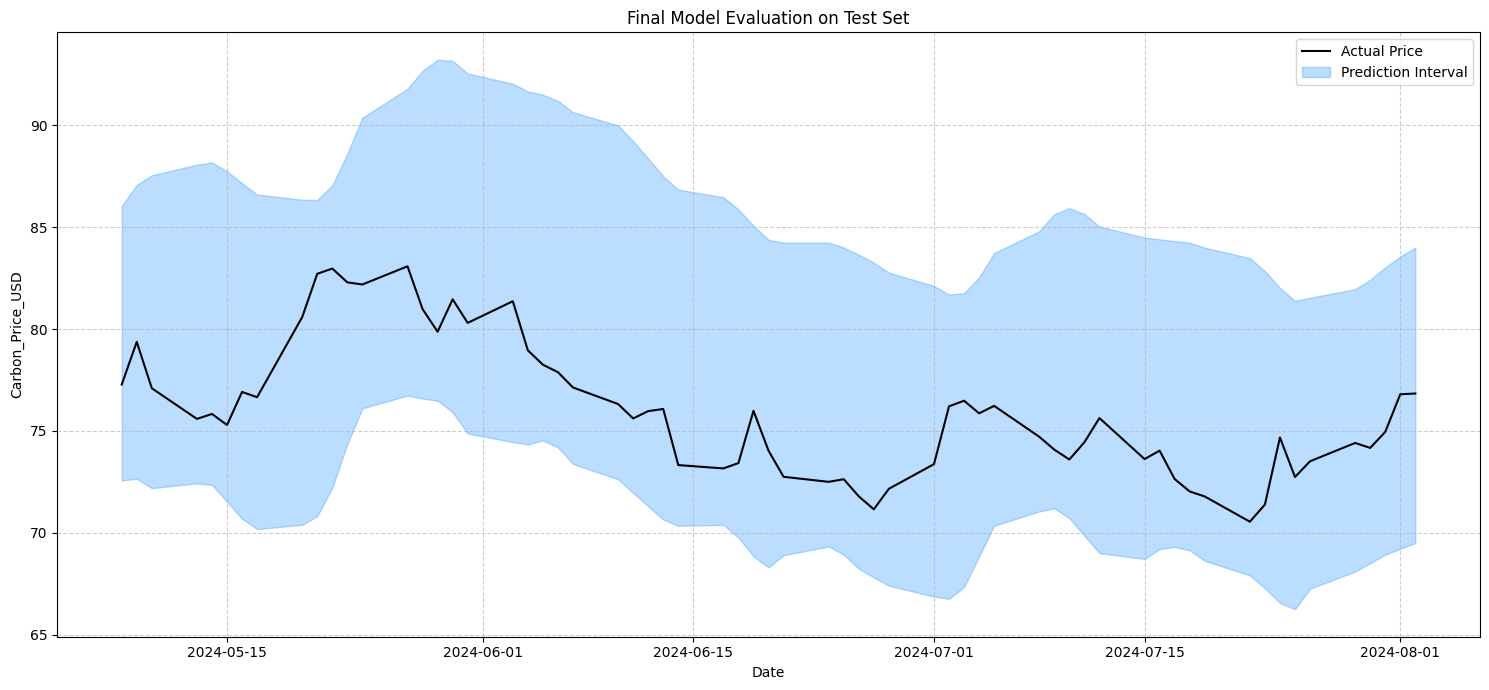

In [ ]:
# 2nd opinion it should be slightly more

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import itertools
import logging

# --- 1. Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "file_path": r"D:\Minor Project\All Models\Interval_Forecast_Normal\df_without_exo.xlsx",
    "target_col": "Carbon_Price_USD",
    "original_features": ['Carbon_Price_USD'],
    
    # --- New Splitting Logic ---
    "test_split_date": '2024-04-01',
    "val_ratio_of_train_data": 0.1, # 10% of the pre-2024 data is used for validation
    
    "target_coverage": 95.0,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "param_grid": {
        'seq_len': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
        'hidden_dim': [32, 48, 64, 96, 128, 160],
        'num_layers': [1, 2, 3],
        'learning_rate': [0.005, 0.01, 0.001],
        'epochs': [100]
    }
}

# --- 2. Model Definition ---
class RNNQuantile(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# --- 3. Pipeline Functions ---

def load_and_clean_data(file_path):
    # This function remains the same as the robust version from before
    logging.info(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path) 
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.sort_values('Date', inplace=True)

    if pd.api.types.is_object_dtype(df['Vol.']):
        logging.info("Volume column contains text. Applying conversion...")
        def convert_volume(vol):
            try:
                if isinstance(vol, str):
                    vol = vol.replace('K', '*1e3').replace('M', '*1e6')
                    return eval(vol)
                return np.nan
            except:
                return np.nan
        df['Vol.'] = df['Vol.'].apply(convert_volume)
    
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')
    df.set_index('Date', inplace=True)
    return df

def engineer_features(df, original_features, target_col):
    # This function also remains the same
    logging.info("Engineering lagged features...")
    for feature in original_features:
        df[f'{feature}_lag1'] = df[feature].shift(1)
    
    feature_cols = [f'{col}_lag1' for col in original_features]
    df.dropna(inplace=True)
    
    if df.empty:
        raise ValueError("DataFrame is empty after feature engineering. Please check input data.")
    
    X = df[feature_cols]
    y = df[[target_col]]
    return X, y

def split_and_scale_data(X, y, test_split_date, val_ratio):
    """
    Splits data into train, validation, and test sets.
    """
    logging.info(f"Splitting test data at date: {test_split_date}")
    test_split_date = pd.to_datetime(test_split_date)

    train_val_mask = X.index < test_split_date
    X_train_val, X_test = X[train_val_mask], X[~train_val_mask]
    y_train_val, y_test = y[train_val_mask], y[~train_val_mask]

    val_split_index = int(len(X_train_val) * (1 - val_ratio))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]

    logging.info(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
         raise ValueError("One of the data splits is empty. Check your split date and ratios.")

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)

    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)
    
    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
            X_test_scaled, y_test_scaled, scaler_y)

def create_sequences(X, y, seq_len):
    # This utility function remains the same
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def train_quantile_model(X_train, y_train, quantile, params):
    # This training utility also remains the same
    model = RNNQuantile(
        X_train.shape[2], 
        params['hidden_dim'], 
        params['num_layers']
    ).to(CONFIG['device'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(CONFIG['device'])
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(CONFIG['device'])

    def quantile_loss(q, y, y_pred):
        e = y - y_pred
        return torch.mean(torch.max(q * e, (q - 1) * e))

    for _ in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = quantile_loss(quantile, y_train_t, y_pred)
        loss.backward()
        optimizer.step()
    return model

def find_best_hyperparameters(train_data, val_data, param_grid, scaler_y):
    """Searches for the best hyperparameters on the validation set."""
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data
    
    valid_models = []
    param_combinations = list(itertools.product(*param_grid.values()))
    logging.info(f"Starting hyperparameter search over {len(param_combinations)} combinations...")

    for values in param_combinations:
        params = dict(zip(param_grid.keys(), values))
        
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, params['seq_len'])
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, params['seq_len'])

        if len(X_val_seq) == 0: continue

        lower_model = train_quantile_model(X_train_seq, y_train_seq, 0.025, params)
        upper_model = train_quantile_model(X_train_seq, y_train_seq, 0.975, params)

        X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(CONFIG['device'])
        with torch.no_grad():
            pred_lower_s = lower_model(X_val_t).cpu().numpy()
            pred_upper_s = upper_model(X_val_t).cpu().numpy()

        pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
        pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
        y_val_true = scaler_y.inverse_transform(y_val_seq).flatten()
        
        # Ensure upper bound is always greater than or equal to lower bound
        pred_upper = np.maximum(pred_lower, pred_upper)

        picp = np.mean((y_val_true >= pred_lower) & (y_val_true <= pred_upper)) * 100
        mpiw = np.mean(pred_upper - pred_lower)

        if picp >= CONFIG['target_coverage']:
            logging.info(f"✓ Valid model found: PICP={picp:.2f}%, MPIW={mpiw:.4f} with params {params}")
            valid_models.append({'mpiw': mpiw, 'params': params})
        else:
            logging.info(f"✗ Model rejected: PICP={picp:.2f}% with params {params}")

    if not valid_models:
        raise ValueError("No valid hyperparameters found that meet the PICP threshold on the validation set.")
        
    # Select the parameters with the lowest MPIW from the valid models
    best_model_info = min(valid_models, key=lambda x: x['mpiw'])
    return best_model_info['params']

def evaluate_on_test_set(best_params, train_val_data, test_data, scaler_y):
    """Trains the final model on combined train+val data and evaluates on the test set."""
    X_train_val_scaled, y_train_val_scaled = train_val_data
    X_test_scaled, y_test_scaled = test_data

    logging.info("Training final model on combined train+validation data...")
    X_train_val_seq, y_train_val_seq = create_sequences(X_train_val_scaled, y_train_val_scaled, best_params['seq_len'])
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, best_params['seq_len'])

    lower_model = train_quantile_model(X_train_val_seq, y_train_val_seq, 0.025, best_params)
    upper_model = train_quantile_model(X_train_val_seq, y_train_val_seq, 0.975, best_params)

    logging.info("Evaluating final model on the test set...")
    X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(CONFIG['device'])
    with torch.no_grad():
        pred_lower_s = lower_model(X_test_t).cpu().numpy()
        pred_upper_s = upper_model(X_test_t).cpu().numpy()

    pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
    pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
    y_test_true = scaler_y.inverse_transform(y_test_seq).flatten()
    pred_upper = np.maximum(pred_lower, pred_upper)
    
    final_picp = np.mean((y_test_true >= pred_lower) & (y_test_true <= pred_upper)) * 100
    final_mpiw = np.mean(pred_upper - pred_lower)

    results = {"picp": final_picp, "mpiw": final_mpiw}
    plot_data = {"pred_lower": pred_lower, "pred_upper": pred_upper, "y_true": y_test_true}
    
    return results, plot_data

def plot_results(plot_data, test_dates):
    """Visualizes the forecast results, focusing on the prediction interval."""
    logging.info("Generating final plot...")
    y_true = plot_data['y_true']
    dates_for_plot = test_dates[-len(y_true):]

    plt.figure(figsize=(15, 7))
    plt.plot(dates_for_plot, y_true, label='Actual Price', color='black', linewidth=1.5)
    plt.fill_between(dates_for_plot, plot_data['pred_lower'], plot_data['pred_upper'], 
                     color='dodgerblue', alpha=0.3, label=f'Prediction Interval')

    plt.title('Final Model Evaluation on Test Set')
    plt.xlabel('Date')
    plt.ylabel(CONFIG['target_col'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. Main Execution ---
def main():
    """Executes the full forecasting pipeline."""
    df = load_and_clean_data(CONFIG['file_path'])
    X, y = engineer_features(df, CONFIG['original_features'], CONFIG['target_col'])
    
    # Updated function call with new parameters
    (X_train_s, y_train_s, X_val_s, y_val_s, 
     X_test_s, y_test_s, scaler_y) = split_and_scale_data(
         X, y, 
         test_split_date=CONFIG['test_split_date'], 
         val_ratio=CONFIG['val_ratio_of_train_data']
    )
    
    best_params = find_best_hyperparameters(
        train_data=(X_train_s, y_train_s),
        val_data=(X_val_s, y_val_s),
        param_grid=CONFIG['param_grid'],
        scaler_y=scaler_y
    )
    
    # Combine train and validation sets for final model training
    X_train_val_s = np.concatenate((X_train_s, X_val_s), axis=0)
    y_train_val_s = np.concatenate((y_train_s, y_val_s), axis=0)
    
    final_results, plot_data = evaluate_on_test_set(
        best_params=best_params,
        train_val_data=(X_train_val_s, y_train_val_s),
        test_data=(X_test_s, y_test_s),
        scaler_y=scaler_y
    )
    
    print("\n" + "="*40)
    logging.info("Final Model Performance on Test Set")
    print("="*40)
    print(f"Best Hyperparameters: {best_params}")
    print(f"Prediction Interval Coverage (PICP): {final_results['picp']:.2f}%")
    print(f"Mean Prediction Interval Width (MPIW): {final_results['mpiw']:.4f}")
    print("="*40 + "\n")
    
    # Correctly identify the test dates for plotting
    test_dates_index = X[X.index >= pd.to_datetime(CONFIG['test_split_date'])].index
    plot_results(plot_data, test_dates=test_dates_index)

if __name__ == "__main__":
    main()